### Visualize and Explore a LDA Topic Model
Evaluate LDA topic models on Daedalus - a yearly book from the Swedish National Museum of Science and Technology.
[![Daedalus](http://digitalamodeller.se/wp-content/uploads/2016/04/modell-2-780x520.jpg)](http://digitalamodeller.se)

### Setup and Initialize Notebook
Import Python libraries and frameworks, and initialize the notebook.

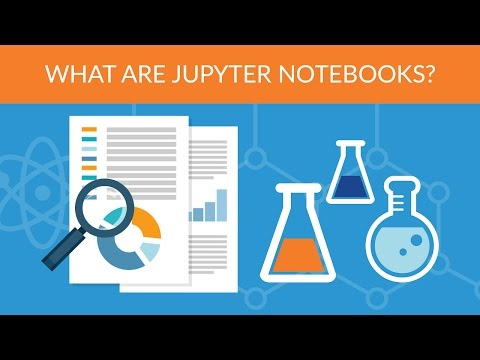

In [14]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo("h9S4kN4l5Is", width=400, height=300)

In [15]:
# Import dependencies and setup notebook
%run ./common/utility
%run ./common/model-utility
%run ./common/plot-utility
%run ./common/widgets-utility

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import os
import glob
import math
import types
import ipywidgets as widgets

from pivottablejs import pivot_ui
from IPython.display import display, HTML, clear_output, IFrame
from itertools import product
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config IPCompleter.greedy=True
%autosave 120

import bokeh.models as bm
import bokeh.palettes

from bokeh.io import output_file, push_notebook
from bokeh.core.properties import value, expr
from bokeh.transform import transform, jitter
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_notebook, output_file

import pandas as pd

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

TOOLS = "pan,wheel_zoom,box_zoom,reset,previewsave"
AGGREGATES = { 'mean': np.mean, 'sum': np.sum, 'max': np.max, 'std': np.std }

output_notebook()

pd.set_option('precision', 10)

Autosaving every 120 seconds


Loading BokehJS ...

### Select LDA Model to be Used in Subsequent Plots
Select one of the avaliable topic models stored in the ./data directory. New models are made avaliable by uploading them into seperate folders in ./data (for instance using Jupyter Lab). Note that the data must have been prepares with the **compute_lda_model.py** script, and all resulting files must be uploaded.
Note that it can take some time (20-30 seconds) to load a model for the first due to large file sizes. Subsequent load is much faster since the system extracts data to CSV-files which gives faster loads.

Note! Subsequent cells are NOT updated automatically when a new model is selected.
Instead you must use the **play** button, or press **Shift-Enter** to execute the current cell.

In [16]:
# Current model state
class ModelState:
    
    def __init__(self, data_folder):
        
        self.data_folder = data_folder
        self.basenames = ModelUtility.get_model_names(data_folder)
        self.basename = self.basenames[0]
        
    def set_model(self, basename=None):

        basename = basename or self.basename
        
        self.basename = basename
      
        self.document_topic_weights = ModelUtility.\
            get_result_model_sheet(self.data_folder, basename, 'doc_topic_weights')\
            .drop('Unnamed: 0', axis=1)
        self.topic_token_weights = ModelUtility\
            .get_result_model_sheet(self.data_folder, basename, 'topic_token_weights')\
            .drop('Unnamed: 0', axis=1)
        self._years = list(range(
            self.document_topic_weights.year.min(), self.document_topic_weights.year.max() + 1))
        self.min_year = min(self._years)
        self.max_year = max(self._years)
        self.years = [None] + self._years
        self.n_topics = self.document_topic_weights.topic_id.max() + 1
        filename = os.path.join(self.data_folder, basename, 'gensim_model_{}.gensim.gz'.format(basename))
        self._lda = None #LdaModel.load(filename)
        self.topic_tokens_as_text = None
        self.corpus_documents = None
        print("Current model: " + self.basename.upper())
        
        return self
    
    def get_document_topic_weights(self, year=None, topic_id=None):
        df = self.document_topic_weights
        if year is None and topic_id is None:
            return df
        if topic_id is None:
            return df[(df.year == year)]
        if year is None:
            return df[(df.topic_id == topic_id)]
        return df[(df.year == year)&(df.topic_id == topic_id)]
    
    def get_unique_topic_ids(self):
        return self.document_topic_weights['topic_id'].unique()
    
    def get_topic_weight_by_year_or_document(self, key='mean', year=None):
        pivot_column = 'year' if year is None else 'document_id'    
        df = self.get_document_topic_weights(year) \
            .groupby([pivot_column,'topic_id']) \
            .agg(AGGREGATES[key])[['weight']].reset_index()
        return df, pivot_column

    def get_lda(self):
        if self._lda is None:
            filename = 'gensim_model_{}.gensim.gz'.format(self.basename)
            self._lda = LdaModel.load(os.path.join(self.data_folder, self.basename, filename))
            print('LDA model loaded...')
        return self._lda 
    
    def get_topics_tokens_as_text(self, n_words=100, cache=True):
        if cache and self.topic_tokens_as_text is not None:
            return self.topic_tokens_as_text
        topic_tokens_as_text = ModelUtility.get_topics_tokens_as_text(state.topic_token_weights, n_words=n_words)
        if cache:
            self.topic_tokens_as_text = topic_tokens_as_text
        return topic_tokens_as_text
    
    def get_topic_tokens(self, topic_id, max_n_words=500):
        tokens = state.topic_token_weights\
            .loc[lambda x: x.topic_id == topic_id]\
            .sort_values('weight',ascending=False)[:max_n_words]
        return tokens

    def get_topic_year_aggregate_weights(self, fn, threshold):
        df = self.document_topic_weights
        #df = df[(df.weight>=threshold)]
        df = df.groupby(['year', 'topic_id']).agg(fn)['weight'].reset_index()
        df = df[(df.weight>=threshold)]
        return df
    
    def get_topic_proportions(self):
        corpus_documents = self.get_corpus_documents()
        document_topic_weights = self.get_document_topic_weights()
        topic_proportion = ModelUtility.compute_topic_proportions(document_topic_weights, corpus_documents)
        return topic_proportion
    
    def get_corpus_documents(self):
        if self.corpus_documents is None:
            self.corpus_documents = ModelUtility.get_corpus_documents(self.data_folder, self.basename)
        return self.corpus_documents

state = ModelState('./tm-data')

wdg_basename = widgets.Dropdown(
    options=state.basenames,
    value=state.basename,
    description='Topic model',
    disabled=False,
    layout=widgets.Layout(width='75%')
)
wdg_model = widgets.interactive(state.set_model, basename=wdg_basename)
display(widgets.VBox((wdg_basename,) + (wdg_model.children[-1],)))
wdg_model.update()


VBox(children=(Dropdown(description='Topic model', layout=Layout(width='75%'), options=('topics_100_NN_PM__no_chunks_iterations_2000_lowercase_ldamodel', 'topics_50_NN_PM__no_chunks_iterations_2000_lowercase_ldamodel', 'topics_150_NN_PM__no_chunks_iterations_2000_lowercase_ldamodel', 'topics_150_NN_PM__no_chunks_iterations_2000_lowercase_ldamallet', 'topics_100_NN_PM__no_chunks_iterations_2000_lowercase_ldamallet', 'topics_50_NN_PM__no_chunks_iterations_2000_lowercase_ldamallet'), value='topics_100_NN_PM__no_chunks_iterations_2000_lowercase_ldamodel'), Output()))

### Documents' Topic-Weight Distribution
This graph displays **the distribution of document topic-weights** for the selected model. The X-axis percentage value between 0 and 100 and the Y-axis is the number of document topic-weights for each (integer) percentage. 

Noteworthy is that the vast majority (97-98)% of the weights are zero, or close to zero. On the other end of the spectrum, a large share of the remaining weights have a very high weight (above 95%)

In [17]:
# Topic Weight Distribution
topic_weights_distribution = state.get_document_topic_weights()
topic_weights_distribution['weight%'] = (topic_weights_distribution.weight * 100).astype('int')
topic_weights_distribution = topic_weights_distribution.groupby('weight%').size()
topic_weights_count = topic_weights_distribution.sum()

def display_topic_weights_distribution(p_range):
    global topic_weights_distribution
    selection = topic_weights_distribution[p_range[0]:p_range[1]+1]
    title = '{0:.2f}% of all document-topic weights are within selected interval'\
          .format(100 * (selection.sum() / topic_weights_count))
    selection.plot(figsize=(12,6), title=title, kind='line', xlim=(0,100))

p_range = widgets.SelectionRangeSlider(
    options=range(0,100), index=(0,99), description='Interval', continues_update=False
)

w = widgets.interactive(display_topic_weights_distribution, p_range=p_range)
display(widgets.VBox(
    (p_range,) +
    (w.children[-1],)))
w.update()

VBox(children=(SelectionRangeSlider(description='Interval', index=(0, 99), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99), value=(0, 99)), Output()))

### Generate Topic Wordclouds

In [19]:
# Display LDA topic's token wordcloud
opts = { 'max_font_size': 100, 'background_color': 'white', 'width': 900, 'height': 800 }

z = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='wc01',
    text=wf.create_text_widget('wc01'),
    topic_id=wf.topic_id_slider(state.n_topics),
    word_count=wf.word_count_slider(1, 500),
    output_format=wf.create_select_widget('Format', ['Wordcloud', 'List', 'Pivot'], default='Wordcloud')

)
z.prev_topic_id = z.create_prev_id_button('topic_id', state.n_topics)
z.next_topic_id = z.create_next_id_button('topic_id', state.n_topics)

def display_wordcloud(topic_id=0, n_words=100, output_format='Wordcloud'):
    global state
    df_temp = state.topic_token_weights
    tokens = state.get_topics_tokens_as_text(n_words=n_words, cache=True).iloc[topic_id]
    z.text.value = 'ID {}: {}'.format(topic_id, tokens)
    if output_format == 'Wordcloud':
        WordcloudUtility.plot_wordcloud(df_temp, 'token', 'weight', max_words=n_words, **opts)
    elif output_format == 'List':
        df_temp = state.get_topic_tokens(topic_id, n_words)
        display(HTML(df_temp.to_html()))
    else:
        display(pivot_ui(state.get_topic_tokens(topic_id, n_words)))
iw = widgets.interactive(display_wordcloud, topic_id=z.topic_id, n_words=z.word_count, output_format=z.output_format)

display(widgets.VBox(
    (z.text,) +
    (widgets.HBox((z.prev_topic_id,) + (z.next_topic_id,) + (z.topic_id,) + (z.word_count,) + (z.output_format,)),) +
    (iw.children[-1],)))
iw.update()


VBox(children=(HTML(value="<span class='wc01'/>", placeholder=''), HBox(children=(Button(description='<<', style=ButtonStyle(button_color='lightgreen')), Button(description='>>', style=ButtonStyle(button_color='lightgreen')), IntSlider(value=0, continuous_update=False, description='Topic ID', max=99), IntSlider(value=50, continuous_update=False, description='Word count', max=500, min=1), Dropdown(description='Format', options=('Wordcloud', 'List', 'Pivot'), value='Wordcloud'))), Output()))

### Display Topic's Word Distribution
The following chart shows the word distribution for each selected topic. You can zoom in on the left chart.

In [21]:
# Display topic's word distribution

def plot_tokens(tokens, **args):
    
    source = ColumnDataSource(tokens)
    
    p = figure(toolbar_location="right", **args)

    cr = p.circle(x='xs', y='ys', source=source)

    label_style = dict(level='overlay', text_font_size='8pt', angle=np.pi/6.0)
    
    text_aligns = ['left', 'right']
    for i in [0, 1]:
        label_source = ColumnDataSource(tokens.iloc[i::2])
        labels = bm.LabelSet(x='xs', y='ys', text_align=text_aligns[i], text='token', text_baseline='middle',
                          y_offset=5*(1 if i == 0 else -1),
                          x_offset=5*(1 if i == 0 else -1),
                          source=label_source, **label_style)
        p.add_layout(labels)
    
    p.xaxis[0].axis_label = 'Token #'
    p.yaxis[0].axis_label = 'Weight'
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "6pt"
    p.axis.major_label_standoff = 0
    return p

    
def plot_topic_tokens_charts(tokens, flag=True):
    
    if flag:
        left = plot_tokens(tokens, plot_width=900, plot_height=600, title='', tools='box_zoom,wheel_zoom,pan,reset')
        show(left)
        return
    
    left = plot_tokens(tokens, plot_width=450, plot_height=500, title='', tools='box_zoom,wheel_zoom,pan,reset')
    right = plot_tokens(tokens, plot_width=450, plot_height=500, title='', tools='pan')

    source = ColumnDataSource({'x':[], 'y':[], 'width':[], 'height':[]})
    left.x_range.callback = create_js_callback('x', 'width', source)
    left.y_range.callback = create_js_callback('y', 'height', source)

    rect = bm.Rect(x='x', y='y', width='width', height='height', fill_alpha=0.0, line_color='blue', line_alpha=0.4)
    right.add_glyph(source, rect)

    show(row(left, right))

def display_topic_tokens(topic_id=0, n_words=100, output_format='Wordcloud'):
    global state, g
    g.progress.value = 1
    tokens = state.get_topic_tokens(topic_id=topic_id).\
        copy()\
        .drop('topic_id', axis=1)\
        .assign(weight=lambda x: 100.0 * x.weight).head(n_words)
    if output_format == 'Wordcloud':
        g.progress.value = 3
        tokens = tokens.assign(xs=tokens.index, ys=tokens.weight)
        plot_topic_tokens_charts(tokens)
        g.progress.value = 4
    elif output_format == 'List':
        #display(tokens)
        display(HTML(tokens.to_html()))
    else:
        display(pivot_ui(tokens))
    g.progress.value = 0
    
g = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='wc01',
    text=wf.create_text_widget('wc01'),
    topic_id=wf.create_int_slider(description='Topic ID', min=0, max=state.n_topics - 1, step=1, value=0),
    word_count=wf.create_int_slider(description='Word count', min=1, max=500, step=1, value=200),
    output_format=wf.create_select_widget('Format', ['Wordcloud', 'List', 'Pivot'], default='Wordcloud'),
    progress = wf.create_int_progress_widget(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%"))

)
g.prev_topic_id = g.create_prev_id_button('topic_id', state.n_topics)
g.next_topic_id = g.create_next_id_button('topic_id', state.n_topics)

w = widgets.interactive(
    display_topic_tokens, topic_id=g.topic_id, n_words=g.word_count, output_format=g.output_format
)

display(widgets.VBox(
    (g.text,) +
    (widgets.HBox((g.prev_topic_id,) + (g.next_topic_id,) + 
        (g.topic_id,) + (g.word_count,) + (g.output_format,)),) +
    (g.progress, ) +
    (w.children[-1],)))

w.update()


VBox(children=(HTML(value="<span class='wc01'/>", placeholder=''), HBox(children=(Button(description='<<', style=ButtonStyle(button_color='lightgreen')), Button(description='>>', style=ButtonStyle(button_color='lightgreen')), IntSlider(value=0, continuous_update=False, description='Topic ID', max=99), IntSlider(value=200, continuous_update=False, description='Word count', max=500, min=1), Dropdown(description='Format', options=('Wordcloud', 'List', 'Pivot'), value='Wordcloud'))), IntProgress(value=0, layout=Layout(width='95%'), max=4), Output()))

###  Plot Topic's Weight Over Time
Display a specific topics share over time as well as listing topic terms in descending order (based on yearly mean weight over all documents). The *whisker* displays max and mean topic weight for given year.

In [23]:
# Plot a topic's yearly weight over time in selected LDA topic model

def plot_topic_over_time(df, pivot_column, value_column, topic_id=0, year=None, whisker=False):

    source = ColumnDataSource(df)
    p = figure(plot_width=900, plot_height=600, title='', tools=TOOLS, toolbar_location="right")
    p.xaxis[0].axis_label = pivot_column.title()
    p.yaxis[0].axis_label = value_column.title() + ('weight' if value_column != 'weight' else '')
    p.y_range.start = 0.0
    p.y_range.end = 1.0

    day_width = 60*60*24*1000
    glyph = bm.glyphs.VBar(x=pivot_column, top=value_column, bottom=0, width=1, fill_color="#b3de69")
    p.add_glyph(source, glyph)
    if whisker and year is None:
        p.add_layout(
            bm.Whisker(source=source, base=pivot_column, upper="max", lower=value_column)
        )
    #if not year is None: print(df_temp[['index', 'document', 'topic_id', 'weight']])
    return p

def display_topic_over_time(topic_id, year, value_column):
    global state, zj

    tokens = state.get_topics_tokens_as_text(n_words=200, cache=True).iloc[topic_id]
    zj.text.value = 'ID {}: {}'.format(topic_id, tokens)

    pivot_column = 'year' if year is None else 'document_id'
    value_column = value_column if year is None else 'weight'
    
    df = state.document_topic_weights[(state.document_topic_weights.topic_id==topic_id)]
    
    if year is None:
        df = df.groupby([pivot_column, 'topic_id']).agg([np.mean, np.max, np.std])['weight'].reset_index()
        df.columns = ['year', 'topic_id', 'mean', 'max', 'std']
    else:
        df = df[(df.year==year)]
        
    p = plot_topic_over_time(df, pivot_column, value_column, topic_id, year,  False)
    show(p)
    
zj = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='topic_share_plot',
    text=wf.create_text_widget('topic_share_plot'),
    year=wf.create_select_widget('Year', options=state.years),
    topic_id=wf.create_int_slider(description='Topic ID', min=0, max=state.n_topics - 1, step=1, value=0),
    output_format=wf.create_select_widget('Format', ['Wordcloud', 'List', 'Pivot'], default='Wordcloud'),
    progress=wf.create_int_progress_widget(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%")),
    aggregate=wf.create_select_widget('Aggregate', list(AGGREGATES.keys()), 'max')

)
zj.prev_topic_id = zj.create_prev_id_button('topic_id', state.n_topics)
zj.next_topic_id = zj.create_next_id_button('topic_id', state.n_topics)

wj = widgets.interactive(
    display_topic_over_time,
    topic_id=zj.topic_id,
    year=zj.year,
    value_column=zj.aggregate
)

display(widgets.VBox(
    (zj.text,) + 
    (widgets.HBox((zj.prev_topic_id,) + (zj.next_topic_id,) + (zj.topic_id,) + (zj.year,) + (zj.aggregate,)),) + 
    (zj.progress,) + 
    (wj.children[-1],)))
wj.update()


VBox(children=(HTML(value="<span class='topic_share_plot'/>", placeholder=''), HBox(children=(Button(description='<<', style=ButtonStyle(button_color='lightgreen')), Button(description='>>', style=ButtonStyle(button_color='lightgreen')), IntSlider(value=0, continuous_update=False, description='Topic ID', max=99), Dropdown(description='Year', options=(None, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014), value=None), Dropdown(description='Aggregate', index=2, options=('mean', 'std', 'max', 'sum'), value='max'))), IntProgress(value=0, layout=Layout(width='95%'), max=4), Output()))

### Plot Stacked Bar of Most Relevant Topics
Display topic shares in descending order as a stacked bar chart. Order is based on selected aggregate function.

In [24]:
# Plot topic shares (year aggregate or per document for selected year)

def prepare_stacked_topic_share_data(key, n_topics, year):
    global state
    pivot_column = 'year' if year is None else 'document_id'
    
    df_data = state.get_document_topic_weights(year)

    df = ModelUtility.get_document_topic_weights_pivot(df_data, AGGREGATES[key], pivot_column)
    df.set_index(pivot_column, inplace=True)
    
    n_topics = min(len(df.columns), n_topics)
    topic_toplist = df[df.columns].sum().sort_values(axis=0, ascending=False)
    df_top = df[topic_toplist[:n_topics].index].copy()

    df = df_top.reset_index()
    df.columns = [ str(x) for x in  df.columns ]
    
    return df, pivot_column, n_topics

def generate_category_colors(n_items, palette=bokeh.palettes.Category20[20]):
    ''' Repeat palette to get n_items colors '''
    colors = (((n_items // len(palette)) + 1) * palette)[:n_items]
    return colors

def plot_stacked_bar_of_topic_over_time(df, pivot_column, key='mean', n_topics=3, year=None, n_words=100):
    
    categories = list(df.columns[1:])
    colors = generate_category_colors(n_topics)
    source = ColumnDataSource(df)
    
    p = figure(plot_width=900, plot_height=800, title=state.basename, tools=TOOLS, toolbar_location="right")
    
    p.xaxis[0].axis_label = key.title() + ' weight'
    p.yaxis[0].axis_label = pivot_column.title()
    
    #legend = [ value(x) for x in categories ]
    #p.hbar_stack(categories, y=pivot_column, source=source, color=colors, height=0.5, legend=legend)
        
    bottoms, tops = [], []
    for i, category in enumerate(categories):
        tops = tops + [category]
        cr = p.hbar(y=pivot_column,
                    left=expr(bm.expressions.Stack(fields=bottoms)),
                    right=expr(bm.expressions.Stack(fields=tops)),
                    color=colors[i],
                    height=0.5,
                    source=source,
                    legend='Topic ' + str(category))
        topic_id = int(category)
        tooltip = 'ID {}: {}'.format(topic_id, state.get_topics_tokens_as_text(n_words=200, cache=True).iloc[topic_id])
        p.add_tools(bm.HoverTool(tooltips=tooltip, renderers=[cr]))
        bottoms = bottoms + [category]
            
    return p

def display_stacked_bar_of_topic_over_time(key='max', n_topics=3, year=None, output_format='Wordcloud'):
    
    global state
    
    ''' Prepare the plot data '''
    
    df, pivot_column, n_topics = prepare_stacked_topic_share_data(key, n_topics, year)
    
    if output_format == 'Wordcloud':
        p = plot_stacked_bar_of_topic_over_time(df, pivot_column, key, n_topics, year)
        show(p)
    elif output_format == 'List':
        #display(tokens)
        display(HTML(df.to_html()))
    else:
        display(pivot_ui(df))
        
zh = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='topic_share_plot',
    text=wf.create_text_widget('topic_share_plot'),
    year=wf.create_select_widget('Year', options=state.years),
    topics_count=wf.create_int_slider(description='Topic count', min=1, max=state.n_topics, step=1, value=3),
    output_format=wf.create_select_widget('Format', ['Wordcloud', 'List', 'Pivot'], default='Wordcloud'),
    progress=wf.create_int_progress_widget(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%")),
    aggregate=wf.create_select_widget('Aggregate', list(AGGREGATES.keys()), 'max')
)    
wh = widgets.interactive(
    display_stacked_bar_of_topic_over_time, n_topics=zh.topics_count,
    key=zh.aggregate, year=zh.year, output_format=zh.output_format
)

display(widgets.VBox(
    (zh.text,) + 
    (widgets.HBox((zh.aggregate,) + (zh.topics_count,) + (zh.year,) + (zh.output_format,)),) + 
    (zh.progress,) + 
    (wh.children[-1],)))

wh.update()


VBox(children=(HTML(value="<span class='topic_share_plot'/>", placeholder=''), HBox(children=(Dropdown(description='Aggregate', index=2, options=('mean', 'std', 'max', 'sum'), value='max'), IntSlider(value=3, continuous_update=False, description='Topic count', min=1), Dropdown(description='Year', options=(None, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014), value=None), Dropdown(description='Format', options=('Wordcloud', 'List', 'Pivot'), value='Wordcloud'))), IntProgress(value=0, layout=Layout(width='95%'), max=4), Output()))

### Display Document-Topic Weights
List aggregated topic weights.

In [25]:
# Folded code
import IPython.display # import display, HTML
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def plot_stacked_bar_of_topic_over_time(key='mean', year=None, output_format=None):
    global state
    pivot_column = 'year' if year is None else 'document_id'   
    df_data = state.get_document_topic_weights(year)
    df_temp = ModelUtility.get_document_topic_weights_pivot(df_data, AGGREGATES[key], pivot_column)
    df_temp.set_index(pivot_column, inplace=True)
    if output_format == 'List':
        display(HTML(df_temp.to_html()))
    else:
        display(pivot_ui(df_temp))

zk = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='topic_share_plot',
    text=wf.create_text_widget('topic_share_plot'),
    year=wf.create_select_widget('Year', options=state.years),
    output_format=wf.create_select_widget('Format', ['List', 'Pivot'], default='List'),
    aggregate=wf.create_select_widget('Aggregate', list(AGGREGATES.keys()), 'max')
) 

wk = widgets.interactive(
    plot_stacked_bar_of_topic_over_time, key=zk.aggregate, year=zk.year, output_format=zk.output_format
)

display(widgets.VBox((zk.text,) +
       (widgets.HBox((zk.aggregate,) + (zk.year,) + (zk.output_format,)),) +
       (wk.children[-1],)))

wk.update()

VBox(children=(HTML(value="<span class='topic_share_plot'/>", placeholder=''), HBox(children=(Dropdown(description='Aggregate', index=2, options=('mean', 'std', 'max', 'sum'), value='max'), Dropdown(description='Year', options=(None, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014), value=None), Dropdown(description='Format', options=('List', 'Pivot'), value='List'))), Output()))

### Scatter plot (or heatmap) of topic shares per year or document
Display topic shares as a scatter plot using gradient color for topic's weight.

In [26]:
# plot_topic_relevance_by_year

def setup_glyph_coloring(df):
    max_weight = df.weight.max()
    #colors = list(reversed(bokeh.palettes.Greens[9]))
    colors = ["#efefef", "#75968f", "#a5bab7", "#c9d9d3", "#e2e2e2", "#dfccce", "#ddb7b1", "#cc7878",
              "#933b41", "#550b1d"]
    mapper = bm.LinearColorMapper(palette=colors, low=df.weight.min(), high=max_weight)
    color_transform = transform('weight', mapper)
    color_bar = bm.ColorBar(color_mapper=mapper, location=(0, 0),
                         ticker=bm.BasicTicker(desired_num_ticks=len(colors)),
                         formatter=bm.PrintfTickFormatter(format=" %5.2f"))
    return color_transform, color_bar

def plot_topic_relevance_by_year(df, xs, ys, glyph, titles, text_id):

    ''' Setup axis categories '''
    x_range = list(map(str, df[xs].unique()))
    y_range = list(map(str, df[ys].unique()))
    
    ''' Setup coloring and color bar '''
    color_transform, color_bar = setup_glyph_coloring(df)
    
    source = ColumnDataSource(df)

    p = figure(title="Topic heatmap", toolbar_location=None, tools="", x_range=x_range,
           y_range=y_range, x_axis_location="above", plot_width=900, plot_height=900)

    args = dict(x=xs, y=ys, source=source, alpha=1.0, hover_color='red')
    
    if glyph == 'Circle':
        cr = p.circle(color=color_transform, **args)
    else:
        cr = p.rect(width=1, height=1, line_color=None, fill_color=color_transform, **args)

    p.x_range.range_padding = 0
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "5pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0
    p.add_layout(color_bar, 'right')
    
    p.add_tools(bm.HoverTool(tooltips=None, callback=WidgetUtility.glyph_hover_callback(
        source, 'topic_id', titles.index, titles, text_id), renderers=[cr]))
    
    return p
    
def display_topic_relevance_by_year(key='max', year=None, glyph='Circle'):
    global state
    titles = ModelUtility.get_topic_titles(state.topic_token_weights, n_words=100)
    df, pivot_column = state.get_topic_weight_by_year_or_document(key=key, year=year)
    df[pivot_column] = df[pivot_column].astype(str)
    df['topic_id'] = df.topic_id.astype(str)
    p = plot_topic_relevance_by_year(df, xs=pivot_column, ys='topic_id', glyph=glyph,
                                     titles=titles, text_id='topic_relevance')
    show(p)
    
u = TopTopicWidgets(0, state.years, aggregates=list(AGGREGATES.keys()), text_id='topic_relevance')
u.glyph = widgets.Dropdown(options=['Circle', 'Square'], value='Circle', description='Glyph', disabled=False)

w = widgets.interactive(display_topic_relevance_by_year, key=u.aggregate, year=u.year, glyph=u.glyph)

display(widgets.VBox((widgets.HBox((u.aggregate,) + (u.glyph,) + (u.year,)),) + (u.text,) + (w.children[-1],)))
        
w.update()

VBox(children=(HBox(children=(Dropdown(description='Aggregate', options=('mean', 'std', 'max', 'sum'), value='mean'), Dropdown(description='Glyph', options=('Circle', 'Square'), value='Circle'), Dropdown(description='Year', options=(None, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014), value=None))), HTML(value="<span class='topic_relevance'/>", placeholder=''), Output()))

### Utility Classes for Network Visualizations

In [27]:
%run ./common/network-utility
%run ./common/vectorspace-utility

###  Plot Topic-to-Document Associations as a Network Visualization 
- FIXME : Ändra till att visa koppling topc till document för ett år (som sättas vi slider)
- Progressbar

In [29]:
# Visualize year-to-topic correlations by means of topic-document-weight dimensional reduction
     
def plot_topic_year_network(network, layout, scale=1.0, titles=None):

    year_nodes, topic_nodes = NetworkUtility.get_bipartite_node_set(network, bipartite=0)  
    
    year_source = NetworkUtility.get_node_subset_source(network, layout, year_nodes)
    topic_source = NetworkUtility.get_node_subset_source(network, layout, topic_nodes)
    lines_source = NetworkUtility.get_edges_source(network, layout, scale=6.0, normalize=False)
    
    edges_alphas = NetworkMetricHelper.compute_alpha_vector(lines_source.data['weights'])
    
    lines_source.add(edges_alphas, 'alphas')
    
    p = figure(plot_width=900, plot_height=900, x_axis_type=None, y_axis_type=None, tools=TOOLS)
    
    r_lines = p.multi_line(
        'xs', 'ys', line_width='weights', alpha='alphas', color='black', source=lines_source
    )
    r_years = p.circle(
        'x','y', size=40, source=year_source, color='lightgreen', level='overlay', line_width=1,alpha=1.0
    )
    
    r_topics = p.circle('x','y', size=25, source=topic_source, color='skyblue', level='overlay', alpha=1.00)
    
    p.add_tools(bm.HoverTool(renderers=[r_topics], tooltips=None, callback=WidgetUtility.\
        glyph_hover_callback(topic_source, 'node_id', text_ids=titles.index, text=titles, element_id='nx_id1'))
    )

    text_opts = dict(
        x='x', y='y', text='name', level='overlay',
        x_offset=0, y_offset=0, text_font_size='8pt'
    )
    
    p.add_layout(
        bm.LabelSet(
            source=year_source, text_color='black', text_align='center', text_baseline='middle', **text_opts
        )
    )
    p.add_layout(
        bm.LabelSet(
            source=topic_source, text_color='black', text_align='center', text_baseline='middle', **text_opts
        )
    )
    
    return p
    
def display_topic_year_network(
    layout_algorithm, threshold=0.10, scale=1.0, year=None, output_format='Network'
):
    global state, zn
    zn.progress.value = 1
    titles = state.get_topics_tokens_as_text()
    df = state.get_document_topic_weights(year=year, topic_id=None)
    df = df[(df.weight >= threshold)]
    zn.progress.value = 2
    
    network = NetworkUtility.create_bipartite_network(df, 'document', 'topic_id')
    zn.progress.value = 3
        
    if output_format == 'Network':
        args = NetworkUtility.layout_args(layout_algorithm, network, scale)
        layout = (layout_algorithms[layout_algorithm])(network, **args)
        zn.progress.value = 4
        p = plot_topic_year_network(network, layout, scale=scale, titles=titles)
        show(p)

    elif output_format == 'List':
        display(HTML(df.to_html()))
    else:
        display(pivot_ui(df))
        
    zn.progress.value = 0

zn = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='nx_id1',
    text=wf.create_text_widget('nx_id1'),
    year=wf.create_int_slider(
        description='Year', min=state.min_year, max=state.max_year, step=1, value=state.min_year
    ),
    scale=wf.create_float_slider('Scale', min=0.0, max=1.0, step=0.01, value=0.1),
    threshold=wf.create_float_slider('Threshold', min=0.0, max=1.0, step=0.01, value=0.10),
    output_format=wf.create_select_widget('Format', ['Network', 'List', 'Pivot'], default='Network'),
    layout=wf.create_select_widget('Layout', list(layout_algorithms.keys()), default='Fruchterman-Reingold'),
    progress=wf.create_int_progress_widget(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%"))
) 
zn.previous = zn.create_prev_id_button('year', 10000)
zn.next = zn.create_next_id_button('year', 10000)

wn = widgets.interactive(
    display_topic_year_network, layout_algorithm=zn.layout,
    threshold=zn.threshold, scale=zn.scale,
    year=zn.year, output_format=zn.output_format
)

display(widgets.VBox(
    (zn.text, ) +
    (widgets.HBox((zn.layout, ) + (zn.year,) + (zn.previous,) + (zn.next,)),) +
    (widgets.HBox((zn.threshold,) + (zn.scale,) + (zn.output_format,)),) +
    (zn.progress, ) +
    (wn.children[-1],)))

wn.update()

VBox(children=(HTML(value="<span class='nx_id1'/>", placeholder=''), HBox(children=(Dropdown(description='Layout', index=4, options=('Kamada-Kawai', 'Shell', 'Circular', 'Eigenvectors of Laplacian', 'Fruchterman-Reingold'), value='Fruchterman-Reingold'), IntSlider(value=1931, continuous_update=False, description='Year', max=2014, min=1931), Button(description='<<', style=ButtonStyle(button_color='lightgreen')), Button(description='>>', style=ButtonStyle(button_color='lightgreen')))), HBox(children=(FloatSlider(value=0.1, continuous_update=False, description='Threshold', max=1.0, step=0.01), FloatSlider(value=0.1, continuous_update=False, description='Scale', max=1.0, step=0.01), Dropdown(description='Format', options=('Network', 'List', 'Pivot'), value='Network'))), IntProgress(value=0, layout=Layout(width='95%'), max=4), Output()))

### Topic Similarity Network
This plot displays topic similarity based on **euclidean or cosine distances** between the **topic-to-word vectors**. Please note that the computations can take some time to exceute, especially for larger LDA models.

1. Compute a multi dimensional topic vector space based on the top n words for each topic. Since the subset of words differs, and their positions differs between topics they need to be aligned in common space so that 1) each vector has the same dimension (i.e. number of unique top n tokens over all topics) and 2) each token has the same position within that space. (using sklearn DictVectorizer). The vector space will have as many dimensions as the number of unique top n words over all topics.
2. Reduce the topic vector space into a 2D space (using sklearn PCA)
3. Normalize the 2D space (sklearn Normalizer)

TODO: DONE Use cosine similarity as alternativ to spatial distance
TODO: Alternative to use 1) DONE topic-term vector space 2) DONE PCA nD 3) T-SNE
TODO: Save network to file (either via pandas or networkx)
TODO: Should partition/community be computed before or after network is filtered?

Note: Steps 1 to 3 above (the most time consuming) are executed whenever an option marked with an asterix is changed. 

In [30]:
# plot_correlation_network

DFLT_NODE_OPTS = dict(color='green', level='overlay', alpha=1.0)
DFLT_EDGE_OPTS = dict(color='black', alpha=0.2)

def project_series_to_range(series, low, high):
    norm_series = series / series.max()
    return norm_series.apply(lambda x: low + (high - low) * x)
    
def plot_correlation_network(
    network,
    layout_algorithm=None,
    scale=1.0,
    threshold=0.0,
    node_description=None,
    node_proportions=None,
    weight_scale=5.0,
    normalize_weights=True,
    node_opts=None,
    line_opts=None
):
    if threshold > 0:
        max_weight = max(nx.get_edge_attributes(network, 'weight').values())
        filter_edges = [(u, v) for u, v, d in network.edges(data=True) if d['weight'] >= (threshold * max_weight)]
        sub_network = network.edge_subgraph(filter_edges)
    else:
        sub_network = network
        
    args = NetworkUtility.layout_args(layout_algorithm, sub_network, scale)
    layout = (layout_algorithms[layout_algorithm])(sub_network, **args)

    lines_source = NetworkUtility.get_edges_source(
        sub_network, layout, scale=weight_scale, normalize=normalize_weights
    )
    nodes_source = NetworkUtility.create_nodes_data_source(sub_network, layout)

    nodes_community = NetworkMetricHelper.compute_partition(sub_network)
    community_colors = NetworkMetricHelper.partition_colors(nodes_community, bokeh.palettes.Category20[20])
    
    nodes_source.add(nodes_community, 'community')
    nodes_source.add(community_colors, 'community_color')
    
    nodes_size = 5
    if node_proportions is not None:
        # NOTE!!! By pd index - not iloc!!
        nodes_weight = node_proportions.loc[list(sub_network.nodes)]
        nodes_weight = project_series_to_range(nodes_weight, 20, 60)
        nodes_size = 'size'
        nodes_source.add(nodes_weight, nodes_size)

    node_opts = extend(DFLT_NODE_OPTS, node_opts or {})
    line_opts = extend(DFLT_EDGE_OPTS, line_opts or {})
    
    p = figure(plot_width=900, plot_height=900, x_axis_type=None, y_axis_type=None) #, tools=tools)
    #node_size = 'size' if node_proportions is not None else 5
    r_lines = p.multi_line('xs', 'ys', line_width='weights', source=lines_source, **line_opts)
    r_nodes = p.circle('x', 'y', size=nodes_size, source=nodes_source, **node_opts)
    
    p.add_tools(bm.HoverTool(renderers=[r_nodes], tooltips=None, callback=WidgetUtility.\
        glyph_hover_callback(nodes_source, 'node_id', text_ids=node_description.index, \
                             text=node_description, element_id='nx_id3'))
    )
    
    text_opts = dict(x='x', y='y', text='name', level='overlay', text_align='center', text_baseline='middle')

    r_nodes.glyph.fill_color = 'community_color'

    p.add_layout(bm.LabelSet(source=nodes_source, text_color='black', **text_opts))
    
    return p

In [31]:
# Visualization
if 'nx_data' not in globals():
    nx_data = types.SimpleNamespace(
        network=None,
        X_n_space=None,
        X_pca_norm=None,
        X_tsne_norm=None,
        distance_matrix=None,
        metric=None,
        reducer=None,
        topic_proportions=None,
        n_words = 0
    )

def plot_clustering_dendogram(clustering):
    plt.figure(figsize=(16,6))
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
    R = dendrogram(clustering)
    plt.show()
    plt.close()

def display_correlation_network(
    layout_algorithm, threshold=0.10, scale=1.0, metric='Euclidean', reducer='tsne', n_words=200):
    global state, data, zy

    zy.progress.value = 1
    metric = DISTANCE_METRICS[metric]
    n_components = 3 if reducer == 'tsne' else 20
    perplexity=30
    
    node_description = state.get_topics_tokens_as_text()
    node_proportions = state.get_topic_proportions()
    
    zy.progress.value = 2
    if nx_data.network is None or \
    nx_data.metric != metric or nx_data.reducer != reducer or nx_data.n_words != n_words:
        nx_data.n_words = n_words
        nx_data.metric, nx_data.reducer = metric, reducer
        nx_data.pca_norm = None
        nx_data.X_n_space, _ = ModelUtility.compute_topic_terms_vector_space(state.get_lda(), n_words=n_words)
        zy.progress.value = 3
        nx_data.X_m_space = VectorSpaceHelper.\
                reduce_dimensions(nx_data.X_n_space, method=reducer,
                                  n_components=n_components, perplexity=perplexity)
            
        zy.progress.value = 5
        nx_data.distance_matrix = VectorSpaceHelper.compute_distance_matrix(nx_data.X_m_space, metric=metric)
        zy.progress.value = 7
        nx_data.network = NetworkUtility.create_network_from_correlation_matrix(nx_data.distance_matrix)

    zy.progress.value = 8
    p = plot_correlation_network(
        network=nx_data.network,
        layout_algorithm=layout_algorithm,
        scale=scale, threshold=threshold,
        node_description=node_description,
        node_proportions=node_proportions
    )
    
    zy.progress.value = 10
    show(p)
    zy.progress.value = 0

zy = BaseWidgetUtility(
    n_topics=state.n_topics,
    text_id='nx_id3',
    text=wf.create_text_widget('nx_id3'),
    scale=wf.create_float_slider('Scale', min=0.0, max=1.0, step=0.01, value=0.1),
    year=wf.create_int_slider(
        description='Year', min=state.min_year, max=state.max_year, step=1, value=state.min_year
    ),
    reducer=wf.create_select_widget(
        label='Reducer*', values=['passthrough','pca','pca_norm','tsne'], default='pca'
    ),
    n_words=wf.create_int_slider(description='#words*', min=10, max=500, step=1, value=200),
    metric=wf.create_select_widget(label='Metric*', values=list(DISTANCE_METRICS.keys()), default='Cosine'),
    threshold=wf.create_float_slider('Threshold', min=0.0, max=1.0, step=0.01, value=0.75),
    output_format=wf.create_select_widget('Format', ['Network', 'List', 'Pivot'], default='Network'),
    layout=wf.create_select_widget('Layout', list(layout_algorithms.keys()), default='Fruchterman-Reingold'),
    progress=wf.create_int_progress_widget(min=0, max=10, step=2, value=0, layout=widgets.Layout(width="95%"))
) 
    
wy = interactive(
    display_correlation_network,
    layout_algorithm=zy.layout,
    threshold=zy.threshold,
    scale=zy.scale,
    metric=zy.metric,
    reducer=zy.reducer,
    n_words=zy.n_words,
    output_format=zy.output_format
)

display(widgets.VBox(
    (zy.text, ) +
    (widgets.HBox((zy.threshold,) + (zy.reducer,) + (zy.metric,) + (zy.output_format,)),) +
    (widgets.HBox((zy.n_words,) + (zy.layout,) + (zy.scale,)),) +
    (zy.progress,) +
    (wy.children[-1],)))

wy.update()
                                   

VBox(children=(HTML(value="<span class='nx_id3'/>", placeholder=''), HBox(children=(FloatSlider(value=0.75, continuous_update=False, description='Threshold', max=1.0, step=0.01), Dropdown(description='Reducer*', index=1, options=('passthrough', 'pca', 'pca_norm', 'tsne'), value='pca'), Dropdown(description='Metric*', index=2, options=('Euclidean', 'Correlation', 'Cosine', 'Squared Euclidean', 'Normalized Euclidean'), value='Cosine'), Dropdown(description='Format', options=('Network', 'List', 'Pivot'), value='Network'))), HBox(children=(IntSlider(value=200, continuous_update=False, description='#words*', max=500, min=10), Dropdown(description='Layout', index=4, options=('Kamada-Kawai', 'Shell', 'Circular', 'Eigenvectors of Laplacian', 'Fruchterman-Reingold'), value='Fruchterman-Reingold'), FloatSlider(value=0.1, continuous_update=False, description='Scale', max=1.0, step=0.01))), IntProgress(value=0, layout=Layout(width='95%'), max=10), Output()))

### Visualization of Topic Similarity using 2D T-SNE Dimensionality Reduction
FIXME: var title = circle.data.words[index]; ska vara var title = circle.data.words[topic_id];???

In [32]:
#
import types
tr_data = types.SimpleNamespace(
    X_n_space=None,
    X_m_space=None,
    n_words=None,
    method=None,
    perplexity=None,
    corpus_documents=state.get_corpus_documents(),
    topic_proportions=state.get_topic_proportions(),
    tokens=state.get_topics_tokens_as_text(n_words=200)
)


In [33]:
# Plot 2d utility function
def plot_2d_vector_space(
    X_2_space, proportions=None, size=(20, 60),
    description=None, dom_id='id99', glyph_style=None, label_style=None
):
    global tr_data
    xs, ys = zip(*X_2_space)
    n_dim = len(xs)
    item_ids = description.index if not description is None else range(0, n_dim)
    
    if proportions is not None:
        proportions = project_series_to_range(proportions, size[0], size[1])
    
    source = ColumnDataSource(
        dict(xs=list(xs),
             ys=list(ys),
             size=proportions if not proportions is None else [size[0]] * n_dim,
             text=description if not description is None else item_ids,
             item_id=item_ids
        )
    )
    p = figure(plot_width=800, plot_height=800, title='', tools=TOOLS)
    
    glyph_style = extend(dict(color='green', alpha=0.2, hover_color='red') , glyph_style or {})
    cr = p.circle(x='xs', y='ys', size='size', source=source, **glyph_style)
    
    label_style = extend(dict(level='overlay', text_align='center', text_baseline='middle',
                              text_font_size='8pt') , label_style or {})
    labels = bm.LabelSet(x='xs', y='ys', text='item_id', source=source, **label_style)
    
    p.add_layout(labels)
    
    p.add_tools(bm.HoverTool(renderers=[cr], tooltips=None, callback=WidgetUtility.\
        glyph_hover_callback(source, 'item_id', text_ids=description.index, text=description, element_id=dom_id))
    )
    
    return p


In [34]:
#
def reduce_and_plot_vector_space(n_words, method='tsne', perplexity=30):
    global state, zc
    
    pp = zc.progress
    
    pp.value = 1
    
    if tr_data.X_n_space is None or tr_data.n_words != n_words:
        tr_data.X_n_space, _ = ModelUtility.compute_topic_terms_vector_space(state.get_lda(), n_words)
        tr_data.X_m_space = None
        
    pp.value = 2
    
    if  tr_data.X_m_space is None or tr_data.method != method or tr_data.perplexity != perplexity:
        tr_data.X_m_space = VectorSpaceHelper.reduce_dimensions(
            tr_data.X_n_space, method=method, n_components=2, perplexity=perplexity
        )
        
    tr_data.n_words = n_words
    tr_data.method = method
    tr_data.perplexity = perplexity
    
    pp.value = 4
    
    p = plot_2d_vector_space(
        tr_data.X_m_space, proportions=tr_data.topic_proportions, size=(20,40),
        description=tr_data.tokens, dom_id='text99'
    )
    pp.value = 5
    show(p)
    pp.value = 0
    
zc = BaseWidgetUtility(
    n_words=wf.create_int_slider(description='Word count', min=10, max=500, step=10, value=50),
    progress=wf.create_int_progress_widget(min=0, max=5, step=1, value=0, layout=widgets.Layout(width="95%")),
    perplexity=wf.create_int_slider(description='Perplexity', min=1, max=100, step=1, value=30),
    reducer=wf.create_select_widget(
        label='Reducer*', values=['pca','pca_norm','tsne'], default='tsne'
    ),
    text=wf.create_text_widget(element_id='text99')
)
wc = interactive(
    reduce_and_plot_vector_space, n_words=zc.n_words, method=zc.reducer, perplexity=zc.perplexity
)

display(widgets.VBox(
    (zc.text, ) +
    (widgets.HBox((zc.n_words,) + (zc.reducer, ) + (zc.perplexity,)),) + 
    (zc.progress, ) +
    (wc.children[-1],)))

wc.update()


VBox(children=(HTML(value="<span class='text99'/>", placeholder=''), HBox(children=(IntSlider(value=50, continuous_update=False, description='Word count', max=500, min=10, step=10), Dropdown(description='Reducer*', index=2, options=('pca', 'pca_norm', 'tsne'), value='tsne'), IntSlider(value=30, continuous_update=False, description='Perplexity', min=1))), IntProgress(value=0, layout=Layout(width='95%'), max=5), Output()))

###  Document Similarity using LDA topic weights
A similarity metric between documents is computed using a distance metric between the of document-topic vectors obtained from applying the trained LDA model. The vector space consists of n coordinates (i.e. 1036 segmented Daedalus articles) in m dimensions where m equals the number of topics. If all coordinates were to be used....  

Problems:

- It is desirable to exclude uninteresting topics from the computation and/or the plot. Documents with a close to even distriibution of topic weights are (clear?) candidates for exclusion.

- Is there an established method of identifying the most (topically) interesting documents?
- Use a goodness of fit to test against uniform discrete density distribution?
  Wasserstein distance? Chi-square? KS-test

#### First attempt using T-SNE

- It is hard to ses clusters.

In [35]:
#https://stackoverflow.com/questions/22433884/python-gensim-how-to-calculate-document-similarity-using-the-lda-model

def compute_document_topic_vector_space(df):

    #''' Filter out topics below given threshold '''
    #df = df[df.weight][['document_id', 'topic_id', 'weight']]

    ''' Create a dict (pair) for each topic-weight row '''
    df['weight_dict'] = df.apply(lambda x: { int(x.topic_id): x.weight}, axis=1)

    ''' Create a list of all dicts for each documents'''
    df = df.groupby('document_id')['weight_dict'].apply(list)

    ''' Merge the list of pair dicts into a single dict '''
    df = df.apply(lambda L: { k: v for d in L for k, v in d.items() } )

    ''' Fit the topic weighs into a sparse matrix (dimensions m_documents X n_topics)'''
    v = DictVectorizer()
    X_m_n_sparse = v.fit_transform(df)

    return X_m_n_sparse

In [36]:
# T-SNE 2D Visualization
if 'ds_data' not in globals():
    ds_data = types.SimpleNamespace(
        X_m_n_sparse=None,
        X_2_space=None,
        threshold=None,
        reducer=None,
        perplexity=None,
        G=None,
        description=state.get_corpus_documents().rename(columns={'document': 'text'})['text']
    )

def plot_document_similarity_by_topics_tsne(threshold=0.001, reducer='tsne', perplexity=30):
    global u, ds_data
    
    df = state.get_document_topic_weights()
    
    u.progress.value = 1
    if ds_data.X_m_n_sparse is None:
        ds_data.X_m_n_sparse = compute_document_topic_vector_space(df)
        ds_data.threshold = threshold
        ds_data.X_2_space = None
    
    u.progress.value = 2
    if ds_data.X_2_space is None or ds_data.reducer != reducer  or ds_data.perplexity != perplexity or ds_data.threshold != threshold:
        ds_data.X_2_space = VectorSpaceHelper.reduce_dimensions(
            ds_data.X_m_n_sparse, method=reducer,
            n_components=2, perplexity=perplexity)
        ds_data.reduce = reducer
        ds_data.perplexity = perplexity
        
    u.progress.value = 3

    description = state.get_corpus_documents().rename(columns={'document': 'text'})['text']
        
    u.progress.value = 4
    p = plot_2d_vector_space(ds_data.X_2_space, proportions=None,
            size=(20,60), description=ds_data.description, dom_id='nx_id4', glyph_style=dict(alpha=0.05))
    
    u.progress.value = 5
    show(p)
    u.progress.value = 0

u = BaseWidgetUtility()
u.threshold = u.create_float_slider('Threshold', min=0.0, max=0.10, step=0.01, value=0.01)
u.reducer = u.create_select_widget(label='Reducer*', values=['pca', 'pca_norm', 'tsne'], default='tsne')
u.progress = u.create_int_progress_widget(min=0, max=5, step=1)
u.perplexity = u.create_int_slider(description='Perplexity', min=1, max=100, step=1, value=30)
u.text = u.create_text_widget(element_id='nx_id4')

w = widgets.interactive(plot_document_similarity_by_topics_tsne,
                threshold=u.threshold,
                reducer=u.reducer,
                perplexity=u.perplexity)

display(widgets.VBox(
    (u.text, ) +
    (widgets.HBox((u.threshold,) + (u.reducer,) + (u.perplexity,) + (u.progress,)),) +
    (w.children[-1],)))

w.update()

VBox(children=(HTML(value="<span class='nx_id4'/>", placeholder=''), HBox(children=(FloatSlider(value=0.01, continuous_update=False, description='Threshold', max=0.1, step=0.01), Dropdown(description='Reducer*', index=2, options=('pca', 'pca_norm', 'tsne'), value='tsne'), IntSlider(value=30, continuous_update=False, description='Perplexity', min=1), IntProgress(value=0, max=5))), Output()))

In [37]:
def plot_similarity_distribution():
    df = state.get_document_topic_weights()
    X_m_n_sparse = compute_document_topic_vector_space(df)
    matrix = VectorSpaceHelper.compute_distance_matrix(X_m_n_sparse, metric='cosine')
    x_dim, y_dim = matrix.shape
    items = ((i, j, matrix[i,j]) for i, j in product(range(0,x_dim), range(0,y_dim)) if i < j)
    ns, nm, ws = list(zip(*items))
    df = pd.DataFrame(dict(n=ns,m=nm,w=ws))
    df['similarity'] = (df.w*1000).astype('int')
    p = df.groupby('similarity').size().iloc[0:970].plot()


### The same data  as a Network


In [18]:

if True or 'cd99' not in globals():
    cd99 = types.SimpleNamespace(
        X_m_n_sparse=None,
        top=None,
        metric=None,
        reducer=None,
        document_topic_weights=state.get_document_topic_weights(),
        corpus_documents=state.get_corpus_documents(),
        topic_proportions=state.get_topic_proportions(),
        G=None
    )

def plot_document_similarity_by_topics_network(
    layout_algorithm, top, metric, reducer
):
    global zu
    scale = 1.0
    threshold = 0.0
    zu.progress.value = 1
    df = cd99.document_topic_weights
    
    zu.progress.value = 2
    if cd99.X_m_n_sparse is None:
        cd99.X_m_n_sparse = compute_document_topic_vector_space(df)
        cd99.metric = None
        zu.progress.value = 3
    metric = DISTANCE_METRICS[metric]
    if cd99.metric != metric or cd99.top != top:
        cd99.top = top
        cd99.metric = metric
        matrix = VectorSpaceHelper.compute_distance_matrix(cd99.X_m_n_sparse, metric=metric)
        #edges = NetworkUtility.matrix_weight_iterator(matrix, threshold)
        edges = NetworkUtility.df_stack_correlation_matrix(matrix, threshold=0.0, n_top=top)
        zu.progress.value = 4
        G = nx.Graph()
        G.add_weighted_edges_from(edges)
        cd99.G = G
        print(nx.info(cd99.G))

    node_ids, degrees = list(zip(*list(cd99.G.degree(cd99.G.nodes()))))
    node_proportions = pd.DataFrame(dict(node_id=node_ids, size=degrees)).set_index('node_id')
    node_proportions['size'] *= 1000
    zu.progress.value = 5
    p = plot_correlation_network(
        network=cd99.G,
        layout_algorithm=layout_algorithm,
        scale=scale,
        threshold=0.0,
        node_description=state.get_corpus_documents(),
        node_proportions=node_proportions,
        weight_scale=1.0,
        normalize_weights=True
    )
    zu.progress.value = 6
    show(p)
    zu.progress.value = 0
    
zu = BaseWidgetUtility(
    text = wf.create_text_widget(element_id='nx_id_5'),
    #scale = wf.create_float_slider('Scale', min=0.0, max=1.0, step=0.1, value=1.0),
    reducer = wf.create_select_widget(label='Reducer*', values=['none','pca','pca_norm','tsne'], default='none'),
    progress = wf.create_int_progress_widget(min=0, max=6, step=1, value=0, layout=widgets.Layout(width="95%")),
    threshold = wf.create_float_slider('Threshold', min=0.01, max=1.0, step=0.01, value=0.1),
    top = wf.create_int_slider('Top', min=100, max=1000, step=100, value=100),
    metric = wf.create_select_widget(label='Metric*', values=list(DISTANCE_METRICS.keys()), default='Cosine'),
    layout_algorithm = wf.layout_algorithm_widget(list(layout_algorithms.keys()), default='Fruchterman-Reingold')
)

wu = widgets.interactive(plot_document_similarity_by_topics_network,
                layout_algorithm=zu.layout_algorithm,
                #threshold=u.threshold,
                top=zu.top,
                metric=zu.metric,
                reducer=zu.reducer)

display(widgets.VBox(
    (zu.text, ) +
    #(zu.threshold,) +
    (widgets.HBox((zu.reducer,) + (zu.metric,)),) +
    (widgets.HBox((zu.layout_algorithm,) + (zu.top,)),) +
    (zu.progress, ) +
    (wu.children[-1],)))

wu.update()

VBox(children=(HTML(value="<span class='nx_id_5'/>", placeholder=''), HBox(children=(Dropdown(description='Reducer*', options=('none', 'pca', 'pca_norm', 'tsne'), value='none'), Dropdown(description='Metric*', options=('Cosine', 'Squared Euclidean', 'Normalized Euclidean', 'Correlation', 'Euclidean'), value='Cosine'))), HBox(children=(Dropdown(description='Layout', index=2, options=('Shell', 'Kamada-Kawai', 'Fruchterman-Reingold', 'Circular', 'Eigenvectors of Laplacian'), value='Fruchterman-Reingold'), IntSlider(value=100, continuous_update=False, description='Top', max=1000, min=100, step=100))), IntProgress(value=0, layout=Layout(width='95%'), max=6), Output()))

### Topic Clustering
Compute topic clustering based on the distances between the T-SNE 2D coordinates. The SciPy linkage() takes an n x m matrice i.e. n points in m-dimensional vector space (can also take a 1D condensed distance matrix).

1. The first plot takes the num_topics x 2 matrix that T-SNE produced as input
2. The second example takes the "raw" vectorized num_topics x num_words matrix  as input i.e same input as to T-SNE


In [19]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute hierarchical/agglomerative clustering.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# https://stackoverflow.com/questions/11917779/how-to-plot-and-annotate-hierarchical-clustering-dendrograms-in-scipy-matplotlib

if False:
    C = linkage(X_reduced, method='single', metric='euclidean', optimal_ordering=False)
else:
    n_words = 50
    X_n_space, _ = ModelUtility.compute_topic_terms_vector_space(current_lda, n_words)
    C = linkage(X_n_space.toarray(), method='single', metric='euclidean', optimal_ordering=False)
    
plt.figure(figsize=(24,12))
R = dendrogram(C, orientation='left')
plt.show()
plt.close()


NameError: name 'current_lda' is not defined

### pyLDAvis

In [ ]:
from IPython.display import IFrame, display
IFrame('./data/{}/pyldavis.html'.format(current_basename), width=900, height=900)


### Compute and Plot Document Similarity using TF-IDF and T-SNE

**FIXME** Fill in real TF-IDF values (from model) for tokens not in top-list (instead of zero)

**FIXME** Simple (to simlple) document similarity metric, use text2vec instead!


In [20]:
from gensim.models.tfidfmodel import TfidfModel
from gensim import corpora
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class TfidfReducer:
    
    def __init__(self):
        self.corpus = corpora.MmCorpus(os.path.join(state.data_folder, state.basename, 'corpus.mm'))
        self.dictionary = corpora.Dictionary.load(os.path.join(state.data_folder, state.basename, 'corpus.dict.gz'))
        self.data_folder = data_folder
        self.basename = basename
        
    def tfidf_vectors(self, tfidf, corpus, n_tokens):
        for document in corpus:
            yield tfidf[document][:n_tokens]

    def tfidf_vectors_as_dicts(self, tfidf, corpus, n_tokens):
        ''' Create a dict(token_1: weight, ..., token_n: weight } for each document '''
        for tfidf_vector in self.tfidf_vectors(tfidf, corpus, n_tokens):
            yield { x[0]: x[1] for x in tfidf_vector }
        
    def fit_transform(self, tfidf, corpus, n_tokens, perplexity=30):

        ''' Align vectors... '''
        v = DictVectorizer()
        dict_vectors = self.tfidf_vectors_as_dicts(tfidf, corpus, n_tokens)
        X = v.fit_transform(dict_vectors)
        feature_names = v.get_feature_names()

        print('Shape: ', X.shape)
        reducer = TSNE(n_components=2, init='pca', random_state=2019, perplexity=perplexity)
        X_reduced = reducer.fit_transform(X.toarray())

        return X, feature_names, X_reduced

class TfidfDocumentWidgets():
    
    def __init__(self, years):
        self.text_id = 'document_text'
        self.text = widgets.HTML(value="<span class='{}'/>".format(self.text_id), placeholder='', description='')
        self.perplexity = widgets.IntSlider(
            min=1, max=200, step=1, value=30, description='Perplexity', continuous_update=False
        )
        self.word_count = widgets.IntSlider(
            min=50, max=250, step=1, value=200, description='Word count', continuous_update=False
        )
        #self.dropdown = widgets.Dropdown(options=[], value='None', description='Dropdown', disabled=False)
        self.year = widgets.Dropdown(
            options=state.years, value=state.years[0], description='Year', disabled=False
        )
        
    def setup_hover_callback_tool(self, cr):
        code = """
        var indices = cb_data.index['1d'].indices;
        if (indices.length > 0) {
            var index = indices[0];
            var topic_id = circle.data.topic_id[index];
            var title = circle.data.words[index];
            //var share = (100.0 * circle.data.topic_proportion[index]).toFixed(1).toString() + '%';
            $('.""" + self.text_id + """').html('DOC ' + topic_id.toString() + ': ' + title);
        }
        """
        callback = CustomJS(args={'document_glyph': cr.data_source}, code=code)
        p.add_tools(HoverTool(tooltips=None, callback=callback, renderers=[cr]))
        return HoverTool(tooltips=None, callback=callback, renderers=[cr])

def plot_tf_idf_document_vector_space(X_reduced, document_index):
    
    xs, ys = zip(*X_reduced)
    source = ColumnDataSource(
        dict(xs=list(xs),
             ys=list(ys),
             #size=5,
             #words=titles,
             #topic_id=titles.index
        )
    )
    p = figure(plot_width=800, plot_height=800, title='', tools=TOOLS)
    cr = p.circle(x='xs', y='ys', size=5, source=source, alpha=0.2, hover_color='red')
    show(p)
    
if 'corpus' is not in globals():
    corpus = corpora.MmCorpus(os.path.join(state.data_folder, state.basename, 'corpus.mm'))
    dictionary = corpora.Dictionary.load(os.path.join(state.data_folder, state.basename, 'corpus.dict.gz'))
    id2document = ModelUtility.get_corpus_documents(data_folder, basename)
    tfidf_corpus = TfidfCorpus(state.data_folder, state.basename, tfidf, corpus, n_tokens=200)
    tfidf = TfidfModel(corpus)

if 'X_reduced' is not in globals():
    ''' This takes some time to compute...'''
    document_tfidf_vectors = tfidf_vectors_as_dicts(tfidf, corpus)
    X, feature_names, X_reduced = compute_document_pca(document_tfidf_vectors)
    
def display_tf_idf_document_vector_space(perplexity, word_count, year):
    global X_reduced
    plot_tf_idf_document_vector_space(X_reduced, perplexity)
    
u = TfidfDocumentWidgets(state.years)
w = interactive(display_tf_idf_document_vector_space,
                perplexity=u.perplexity, word_count=u.word_count, year=u.year)

display(widgets.VBox(
    (u.text,) + (widgets.HBox((u.year,) + (u.perplexity,) + (u.word_count,)),)
    + (w.children[-1],)))
        
# w.update()

SyntaxError: invalid syntax (<ipython-input-20-066dde0ceb7f>, line 83)

### TODO: Document similarity using BOW document vectorization:
https://de.dariah.eu/tatom/working_with_text.html


Goodness of Fit using **Kolmogorov-Smirnov** (alternatives are **chi square** and **maximum likelihood**) 

https://stats.stackexchange.com/questions/113464/understanding-scipy-kolmogorov-smirnov-test
*"For the KS test the p-value is itself distributed uniformly in [0,1] if the H0 is true (which it is if you test whether it your sample is from U(0,1)U(0,1) and the random number generation works okay). It therefore must "vary wildly" between 0 and 1, in fact its standard deviation is 1/12−−√1/12 which is roughly 0.3."*

https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
*"The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The null distribution of this statistic is calculated under the null hypothesis that the sample is drawn from the reference distribution (in the one-sample case) or that the samples are drawn from the same distribution (in the two-sample case). In each case, the distributions considered under the null hypothesis are continuous distributions but are otherwise unrestricted....The Kolmogorov–Smirnov test can be modified to serve as a goodness of fit test. "* 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

scipy.stats.wasserstein_distance


In [82]:
# https://stats.stackexchange.com/questions/113464/understanding-scipy-kolmogorov-smirnov-test

import numpy as np
import scipy
a = np.random.uniform(size=4999)

print(scipy.stats.kstest(a, 'uniform'))

rvs = df.loc[(df.document_id==0)]['weight']

scipy.stats.kstest(rvs,'uniform')
stats.kstest([1,2,3,4,5,6], 'uniform')


KstestResult(statistic=0.009881293870079855, pvalue=0.713492848840684)


NameError: name 'df' is not defined

In [ ]:
import pandas as pd
from bokeh.layouts import row
category_size = 100

topic_weights = state.get_document_topic_weights()[['document_id', 'topic_id', 'weight']]

sd = topic_weights.weight.apply(lambda x: int(category_size * x))
s_count = len(topic_weights)

sd = sd[sd>0]
v_count = len(sd)
x_count = s_count - v_count
d_count = len(topic_weights.document_id.unique())
t_count = len(topic_weights.topic_id.unique())

print('The data consists of {} documents, {} topics giving {} topic shares'.format(d_count, t_count, s_count))
print('As much as {0:.2f}% of the documents topic shares are 0 ({1} out of {2})'.format(
    100*x_count/s_count,x_count,s_count))
print("The following graphs show the distribution of topic shares in absolute number and percentages")

ys = sd[sd>0].groupby(sd).size()
xs = ys.index
ysp = ys.apply(lambda x: x/v_count)

p1 = figure(width=400, height=400, tools='',
    x_axis_label='Number of topic shares',
    y_axis_label='Percentage of all topics having that share')

cd = p1.vbar(x=xs,width=1,top=ys,line_width=2)
            
p2 = figure(width=400, height=400, tools='',
    x_axis_label='Topic''s share in document (percentage)',
    y_axis_label='Percentage of all topics having that share')

cd = p2.line(x=xs, y=ysp, line_width=2)
show(row(p1,p2))


### Citing

To cite NetworkX please use the following publication:

*Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008*

@inproceedings{rehurek_lrec,
      title = {{Software Framework for Topic Modelling with Large Corpora}},
      author = {Radim {\v R}eh{\r u}{\v r}ek and Petr Sojka},
      booktitle = {{Proceedings of the LREC 2010 Workshop on New
           Challenges for NLP Frameworks}},
      pages = {45--50},
      year = 2010,
      month = May,
      day = 22,
      publisher = {ELRA},
      address = {Valletta, Malta},
      note={\url{http://is.muni.cz/publication/884893/en}},
      language={English}
}